# Integrated gradients

This tutorial demonstrates how to implement **Integrated Gradients (IG)**, an explainable AI technique described in the paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365). IG aims to explain the relationship between a model's predictions in terms of its features. It has many use cases including understanding feature importances, identifying data skew, and debugging model performance.

IG has become a popular interpretability technique due to its broad applicability to any differentiable model, ease of implementation, theoretical justifications, and computational efficiency relative to alternative approaches that allows it to scale to large networks and feature spaces such as images.

You will start by walking through an implementation of IG step-by-step. Next, you will apply IG attributions to understand the pixel feature importances of an image classifier and explore applied machine learning use cases. Lastly, you will conclude with discussion of IG's properties, limitations, and suggestions for next steps in your learning journey.

To motivate this tutorial, here is the result of using IG to highlight important pixels that were used to classify this [image](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg) as a fireboat.

![Output Image 1](./assets/images/IG_fireboat.png)


## Explaining an image classifier

In [1]:
import matplotlib.pylab as plt
import numpy as np
import math
import sys
import tensorflow as tf
import tensorflow_hub as hub

### Download Inception V1 from TF-Hub

**TensorFlow Hub Module**

IG can be applied to any neural network. To mirror the paper's implementation, you will use a pre-trained version of [Inception V1]((https://arxiv.org/abs/1409.4842)) from [TensorFlow Hub](https://tfhub.dev/google/imagenet/inception_v1/classification/4).


In [2]:
inception_v1_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"

In [3]:
inception_v1_classifier = tf.keras.Sequential([
    hub.KerasLayer(name='inception_v1', 
                   handle=inception_v1_url, 
                   trainable=False),
])
inception_v1_classifier.build([None, 224, 224, 3])
inception_v1_classifier.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v1 (KerasLayer)    (None, 1001)              6633209   
Total params: 6,633,209
Trainable params: 0
Non-trainable params: 6,633,209
_________________________________________________________________


From the TF Hub module page, you need to keep in mind the following about Inception V1 for image classification:

**Inputs**: The expected input shape for the model is `(None, 224, 224, 3,)`. This is a dense 4D tensor of dtype float32 and shape `(batch_size, height, width, RGB channels)` whose elements are RGB color values of pixels normalized to the range [0, 1]. The first element is `None` to indicate that the model can take any integer batch size.

**Outputs**: A `tf.Tensor` of logits in the shape of `(n_images, 1001)`. Each row represents the model's predicted score for each of ImageNet's 1,001 classes. For the model's top predicted class index you can use `tf.argmax(predictions, axis=-1)`. Furthmore, you can also covert the model's logit output to predicted probabilities across all classes using `tf.nn.softmax(predictions, axis=-1)` to quantify the model's uncertainty as well as explore similar predicted classes for debugging.

In [4]:
def load_imagenet_labels(file_path):
    """
        Args:
        file_path(str): A URL download path.
        Returns:
        imagenet_label_array(numpy.ndarray): Array of strings with shape (1001,).
    """
    labels_file = tf.keras.utils.get_file('ImageNetLabels.txt', file_path)
    with open(labels_file, "r") as reader:
        f = reader.read()
        labels = f.splitlines()
    imagenet_label_array = np.array(labels)

    return imagenet_label_array

In [5]:
imagenet_label_vocab = load_imagenet_labels('https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')

### Load and preprocess images with `tf.image`

You will illustrate IG using several images. Links to the original images are as follows ([Fireboat](https://commons.wikimedia.org/wiki/File:San_Francisco_fireboat_showing_off.jpg), [Giant Panda](https://commons.wikimedia.org/wiki/File:Giant_Panda_2.JPG)).


In [6]:
def parse_image(file_name):
  """
  This function downloads and standardizes input JPEG images for the 
    inception_v1 model. Its applies the following processing:
    - Reads JPG file.
    - Decodes JPG file into colored image.
    - Converts data type to standard tf.float32.
    - Resizes image to expected Inception V1 input dimension of
      (224, 224, 3) with preserved aspect ratio. E.g. don't stretch image.
    - Pad image to (224, 224, 3) shape with black pixels.
  Args:
    file_name(str): Direct URL path to the JPG image.
  Returns:
    image(Tensor): A Tensor of floats with shape (224, 224, 3).
    label(str): A text label for display above the image.
  """
  image = tf.io.read_file(file_name)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, (224, 224), preserve_aspect_ratio=True)
  image = tf.image.resize_with_pad(image, target_height=224, target_width=224)

  return image

In [7]:
# img_name_url {image_name: origin_url}
img_name_url = {
    'Fireboat': 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg',
    'Giant Panda': 'http://storage.googleapis.com/download.tensorflow.org/example_images/Giant_Panda_2.jpeg',
}

In [8]:
# img_name_path {image_name: downloaded_image_local_path}
img_name_path = {name: tf.keras.utils.get_file(name, url) for (name, url) in img_name_url.items()}

In [9]:
# img_name_tensors {image_name: parsed_image_tensor}
img_name_tensors = {name: parse_image(img_path) for (name, img_path) in img_name_path.items()}

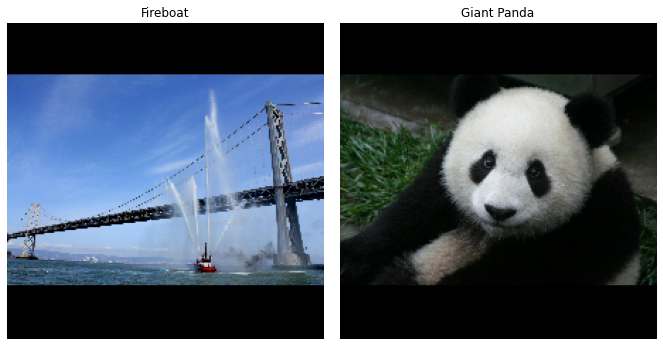

In [10]:
plt.figure(figsize=(14,14))
for n, (name, img_tensors) in enumerate(img_name_tensors.items()):
    ax = plt.subplot(3,3,n+1)
    ax.imshow(img_tensors)
    ax.set_title(name)
    ax.axis('off')
plt.tight_layout()

## Applying integrated gradients

IG is an elegant and simple idea to explain a model's predictions in relation to its input. The basic intuition is to measure a feature's importance to your model by incrementally increasing a feature's intensity between its absense (baseline) and its input value, compute the change between your model's predictions with respect to the original feature at each step, and average these incremental changes together. To gain a deeper understanding for how IG works, you will walk through its application over the sub-sections below.

### Step 1: Identify model input and output tensors

IG is a post-hoc explanatory method that works with any differentiable model regardless of its implementation. As such, you can pass any input example tensor to a model to generate an output prediction tensor. Note that InceptionV1 outputs a multiclass un-normalized logits prediction tensor. So you will use a softmax operator to turn the logits tensor into an output softmax predicted probabilities tensor for use to compute IG feature attributions.

In [11]:
# stack images into a batch for processing.
image_titles = tf.convert_to_tensor(list(img_name_tensors.keys()))
image_batch = tf.convert_to_tensor(list(img_name_tensors.values()))
image_batch.shape

TensorShape([2, 224, 224, 3])

In [12]:
def top_k_predictions_scores_labels(model, img, label_vocab, top_k=3):
  """
  Args:
    model(tf.keras.Model): Trained Keras model.
    img(tf.Tensor): A 4D tensor of floats with the shape 
      (img_n, img_height, img_width, 3).
    label_vocab(numpy.ndarray): An array of strings with shape (1001,).
    top_k(int): Number of results to return.
  Returns:
    k_predictions_idx(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.int32 
      prediction indicies.
    k_predictions_proba(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.float32 
      prediction probabilities.
    k_predictions_label(tf.Tensor): A tf.Tensor [n_images, top_k] of tf.string 
      prediction labels.   
  """
  # These are logits (unnormalized scores).
  predictions = model(img)
  # Convert logits into probabilities.
  predictions_proba = tf.nn.softmax(predictions, axis=-1)
  # Filter top k prediction probabilities and indices.
  k_predictions_proba, k_predictions_idx = tf.math.top_k(
      input=predictions_proba, k=top_k)
  # Lookup top k prediction labels in label_vocab array.
  k_predictions_label = tf.convert_to_tensor(
      label_vocab[k_predictions_idx.numpy()], 
      dtype=tf.string)

  return k_predictions_idx, k_predictions_label, k_predictions_proba

In [13]:
def plot_img_predictions(model, img, img_titles, label_vocab, top_k=3):
  """Plot images with top_k predictions.
  Args:
    model(tf.keras.Model): Trained Keras model.
    img(Tensor): A 4D Tensor of floats with the shape 
      (img_n, img_height, img_width, 3).
    img_titles(Tensor): A Tensor of strings with the shape 
      (img_n, img_height, img_width, 3).
    label_vocab(numpy.ndarray): An array of strings with shape (1001,).
    top_k(int): Number of results to return.
  Returns:
    fig(matplotlib.pyplot.figure): fig object to utilize for displaying, saving 
      plots.
  """
  pred_idx, pred_label, pred_proba = \
  top_k_predictions_scores_labels(
      model=model, 
      img=img, 
      label_vocab=label_vocab, 
      top_k=top_k)
  
  img_arr = img.numpy()
  title_arr = img_titles.numpy()
  pred_idx_arr = pred_idx.numpy()
  pred_label_arr = pred_label.numpy()
  pred_proba_arr = pred_proba.numpy()

  n_rows = img_arr.shape[0]
  # Preserve image height by converting pixels to inches based on dpi.
  size = n_rows * (224 // 48)
  
  fig, axs = plt.subplots(nrows=img_arr.shape[0], ncols=1, figsize=(size, size), squeeze=False)
  for idx, image in enumerate(img_arr):
    axs[idx, 0].imshow(image)
    axs[idx, 0].set_title(title_arr[idx].decode('utf-8'), fontweight='bold')
    axs[idx, 0].axis('off')
    for k in range(top_k):
      k_idx = pred_idx_arr[idx][k]
      k_label = pred_label_arr[idx][k].decode('utf-8')
      k_proba = pred_proba_arr[idx][k]
      if k==0:
        s = 'Prediction {:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
        axs[idx, 0].text(244 + size, 102+(k*40), s, fontsize=12, fontweight='bold')
      else:
        s = 'Prediction {:}: ({:}-{:}) Score: {:.1%}'.format(k+1, k_idx, k_label, k_proba)
        axs[idx, 0].text(244 + size, 102+(k*20), s, fontsize=12)

  plt.tight_layout()      

  return fig


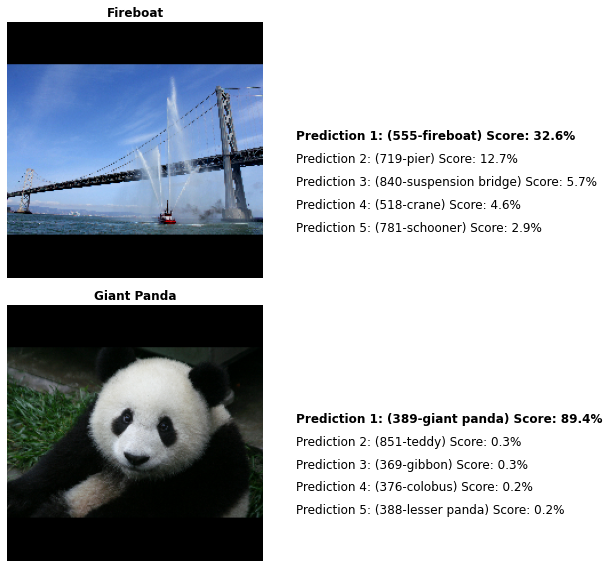

In [14]:
_ = plot_img_predictions(
    model=inception_v1_classifier,
    img=image_batch,
    img_titles=image_titles,
    label_vocab=imagenet_label_vocab, 
    top_k=5
    )

### Step 2: establish baseline to compare inputs against

Defining missingness or a starting point in feature spaces for comparison is at the core of machine learning interpretability methods. For IG, this concept is encoded as a baseline. A **baseline** is an uniformative input used as a starting point for defining IG attributions in relation to and essential for interpreting IG prediction attributions as a function of individual input features.

When selecting a baseline for neural networks, the goal is to choose a baseline such as the prediction at the baseline is near zero to minimize aspects of the baseline impacting interpretation of the prediction attributions.

For image classification networks, a baseline image with its pixels set to 0 meets this objective. For text networks, an all zero input embedding vector makes for a good baseline. Models with structured data that typically involve a mix of continuous numeric features will typically use the observed median value as a baseline because 0 is an informative value for these features. Note, however, that this changes the interpretation of the features to their importance in relation to the baseline value as opposed to the input data directly. The paper author's provide additional guidance on baseline selection for different input feature data types and models under a [How to Use Integrated Gradients Guide](https://github.com/ankurtaly/Integrated-Gradients/blob/master/howto.md#sanity-checking-baselines) on Github.

In [15]:
# name_baseline_tensors. Set random seed for reproducibility of random baseline image and associated attributions.
tf.random.set_seed(42)
name_baseline_tensors = {
    'Baseline Image: Black': tf.zeros(shape=(224,224,3)),
    'Baseline Image: Random': tf.random.uniform(shape=(224,224,3), minval=0.0, maxval=1.0),
    'Baseline Image: White': tf.ones(shape=(224,224,3)),
}

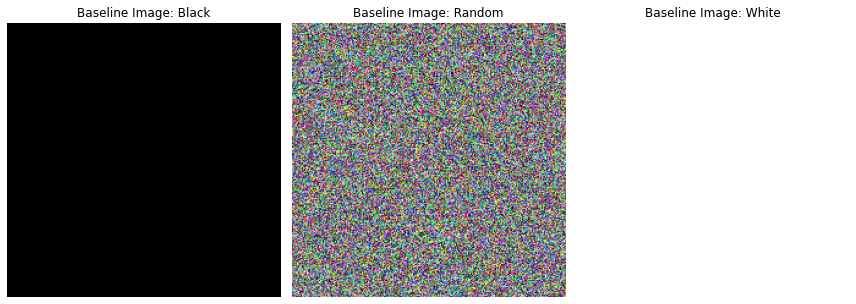

In [16]:
plt.figure(figsize=(12,12))
for n, (name, baseline_tensor) in enumerate(name_baseline_tensors.items()):
  ax = plt.subplot(1,3,n+1)
  ax.imshow(baseline_tensor)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

### Step 3: Integrated gradients in TensorFlow 2.x

The exact formula for Integrated Gradients from the original paper is the following:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input    
$x'$ = baseline   
$\alpha$ = interpolation constant to perturbe features by

However, in practice, computing a definite integral is not always numerically possible and computationally costly so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)   
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral. This is covered in depth in the section *Compute integral approximation* below.


You will walk through the intuition and implementation of the above equation in the sections below.

#### Generate interpolated path inputs

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{generate m interpolated images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

The first step is to generate a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) path between your known baseline and input images. You can think of interpolated images as small steps in the feature space between each feature pixel between your baseline and input images. These steps are represented by $\alpha$ in the original equation. You will revisit $\alpha$ in greater depth in the subsequent section *Compute approximate integral* as its values are tied to the your choice of integration approximation method.

For now, you can use the handy `tf.linspace` function to generate a `Tensor` with 20 m_steps at k linear intervals between 0 and 1 as an input to the `generate_path_inputs` function below.

In [17]:
m_steps=20
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [19]:
def generate_path_inputs(baseline,
                         input,
                         alphas):
    """Generate m interpolated inputs between baseline and input features.
    Args:
    baseline(Tensor): A 3D image tensor of floats with the shape 
      (img_height, img_width, 3).
    input(Tensor): A 3D image tensor of floats with the shape 
      (img_height, img_width, 3).
    alphas(Tensor): A 1D tensor of uniformly spaced floats with the shape 
      (m_steps,).
    Returns:
    path_inputs(Tensor): A 4D tensor of floats with the shape 
      (m_steps, img_height, img_width, 3).
    """
    # Expand dimensions for vectorized computation of interpolations.
    alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
    baseline_x = tf.expand_dims(baseline, axis=0)
    input_x = tf.expand_dims(input, axis=0) 
    delta = input_x - baseline_x
    path_inputs = baseline_x +  alphas_x * delta

    return path_inputs

Generate interpolated images along a linear path at alpha intervals between a black baseline image and the example "Giant Panda" image.

In [20]:
path_inputs = generate_path_inputs(
    baseline=name_baseline_tensors['Baseline Image: Black'], 
    input=img_name_tensors['Giant Panda'],
    alphas=alphas)

In [21]:
path_inputs.shape

TensorShape([21, 224, 224, 3])

The interpolated images are visualized below. Note that another way of thinking about the $\alpha$ constant is that it is monotonically and consistently increasing each interpolated image's intensity.

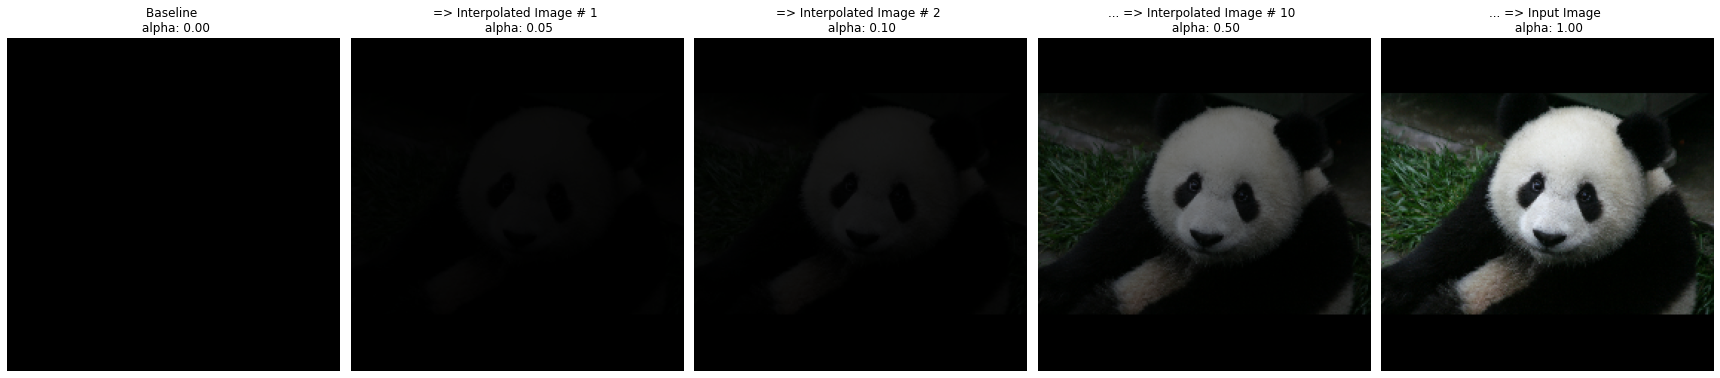

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(24, 24))

axs[0,0].set_title('Baseline \n alpha: {:.2f}'.format(alphas[0]))
axs[0,0].imshow(path_inputs[0])
axs[0,0].axis('off')

axs[0,1].set_title('=> Interpolated Image # 1 \n alpha: {:.2f}'.format(alphas[1]))
axs[0,1].imshow(path_inputs[1])
axs[0,1].axis('off')

axs[0,2].set_title('=> Interpolated Image # 2 \n alpha: {:.2f}'.format(alphas[2]))
axs[0,2].imshow(path_inputs[2])
axs[0,2].axis('off')

axs[0,3].set_title('... => Interpolated Image # 10 \n alpha: {:.2f}'.format(alphas[10]))
axs[0,3].imshow(path_inputs[10])
axs[0,3].axis('off')

axs[0,4].set_title('... => Input Image \n alpha: {:.2f}'.format(alphas[-1]))
axs[0,4].imshow(path_inputs[-1])
axs[0,4].axis('off')

plt.tight_layout();

#### Compute gradients

Now that you generated 20 interpolated images between a black baseline and your example "Giant Panda" photo, lets take a look at how to calculate [gradients](https://en.wikipedia.org/wiki/Gradient) to measure the relationship between changes to your feature pixels and changes in your model's predictions.


The gradients of F, your Inception V1 model function, represents the direction of maximum increase between your predictions with respect to your input. In the case of images, your gradient tells you which pixels have the steepest local slope between your output model's predicted class probabilities with respect to the original pixels.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{Compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

where:  
$F()$ = your model's prediction function  
$\frac{\partial{F}}{\partial{x_i}}$ = gradient (vector of partial derivatives $\partial$) of your model F's prediction function relative to each feature $x_i$  

TensorFlow 2.x makes computing gradients extremely easy for you with the [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape) object which performantly computes and records gradient operations.

In [23]:
def compute_gradients(model, path_inputs, target_class_idx):
  """Compute gradients of model predicted probabilties with respect to inputs.
  Args:
    mode(tf.keras.Model): Trained Keras model.
    path_inputs(Tensor): A 4D tensor of floats with the shape 
      (m_steps, img_height, img_width, 3).
    target_class_idx(Tensor): A 0D tensor of an int corresponding to the correct
      ImageNet target class index.
  Returns:
    gradients(Tensor): A 4D tensor of floats with the shape 
      (m_steps, img_height, img_width, 3).
  """
  with tf.GradientTape() as tape:
    tape.watch(path_inputs)
    predictions = model(path_inputs)
    # Note: IG requires softmax probabilities; converting Inception V1 logits.
    outputs = tf.nn.softmax(predictions, axis=-1)[:, target_class_idx]      
  gradients = tape.gradient(outputs, path_inputs)

  return gradients

Compute gradients between your model Inception V1's predicted probabilities for the target class on each interpolated image with respect to each interpolated input. Recall that your model returns a `(1, 1001)` shaped `Tensor` with of logits that you will convert to predicted probabilities for every class. You need to pass the correct ImageNet target class index to the `compute_gradients` function below in order to identify the specific output tensor you wish to explain in relation to your input and baseline.

In [24]:
path_gradients = compute_gradients(
    model=inception_v1_classifier, 
    path_inputs=path_inputs, 
    target_class_idx=389)

Note the output shape `(n_interpolated_images, img_height, img_width, RGB)`.

Below you can see the local gradients visualized for the first 5 interpolated inputs relative to the input "Giant Panda" image as a series of ghostly shapes. You can think these gradients as measuring the change in your model's predictions for each small step in the feature space. *The largest gradient magnitudes generally occur at the lowest alphas*.

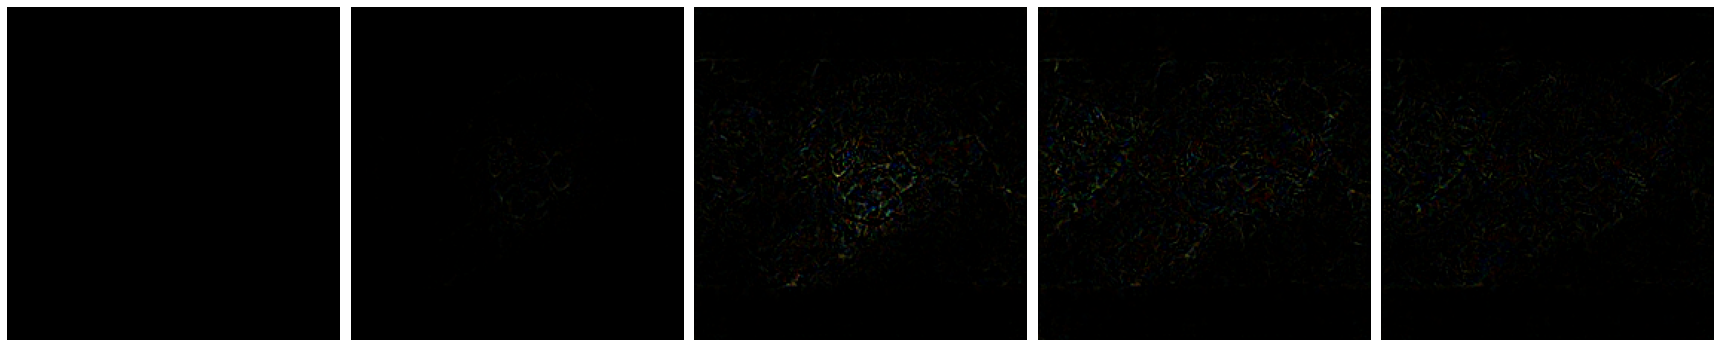

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=5, squeeze=False, figsize=(24, 24))
for i in range(5):
  axs[0,i].imshow(tf.cast(255 * path_gradients[i], tf.uint8), cmap=plt.cm.inferno)
  axs[0,i].axis('off')
plt.tight_layout()

**Why not just use gradients for attribution? Saturation**

You may be wondering at this point, why not just compute the gradients of the predictions with respect to the input as feature attributions? Why bother with slowly changing the intensity of the input image at all? The reason why is networks can *saturate*, meaning the magnitude of the local feature gradients can become extremely small and go toward zero resulting in important features having a small gradient. *The implication is that saturation can result in discontinuous feature importances and miss important features.*

This concept is visualized in the 2 graphs below:

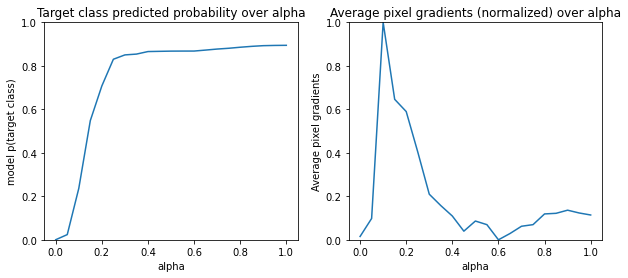

In [26]:
pred = inception_v1_classifier(path_inputs)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, 389]

plt.figure(figsize=(10,4))
ax1 = plt.subplot(1,2,1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0,1])

ax2 = plt.subplot(1,2,2)
# Average across interpolation steps
average_grads = tf.math.reduce_mean(path_gradients, axis=[1,2,3])
# Normalize average gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0,1]);

Notice in the left plot above, how the model prediction function quickly learns the correct "Giant Panda" class when alpha is between 0.0 and 0.3 and then largely flattens between 0.3 and 1.0. There could still be features that the model relies on for correct prediction that differ from the baseline but the magnitudes of those feature gradients become really small and bounce around 0 starting from 0.3 to 1.0. 

Similarly, in the right plot of the average pixel gradients plotted over alpha, you can see the peak "aha" moment where the model learns the target "Giant Panda" but also that the gradient magnitudes quickly minimize toward 0 and even become discontinuous briefly around 0.6. In practice, this can result in gradient attributions to miss important features that differ between input and baseline and to focus on irrelvant features.

**The beauty of IG is that is solves the problem of discontinuous gradient feature importances by taking small steps in the feature space to compute local gradients between predictions and inputs across the feature space and then averages these gradients together to produce IG feature attributions.**


#### Compute integral approximation

There are many different ways you can go about computing the numeric approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called [Riemann sums](https://en.wikipedia.org/wiki/Riemann_sum). The code below shows the visual geometric interpretation for Left, Right, Midpoint, and Trapezoidal Riemann Sums for intuition below:

In [27]:
def plot_riemann_sums(fn, start_val, end_val, m_steps=10):
  """
  Plot Riemann Sum integral approximations for single variable functions.
  Args:
    fn(function): Any single variable function.
    start_val(int): Minimum function value constraint.
    end_val(int): Maximum function value constraint.
    m_steps(int): Linear interpolation steps for approximation.
  Returns:
    fig(matplotlib.pyplot.figure): fig object to utilize for displaying, saving 
      plots.
  """
  # fn plot args
  x = tf.linspace(start_val, end_val, m_steps**2+1)
  y = fn(x)

  fig = plt.figure(figsize=(16,4))

  # Left Riemann Sum
  lr_ax = plt.subplot(1,4,1)
  lr_ax.plot(x, y)
  lr_x = tf.linspace(0.0, 1.0, m_steps+1)
  lr_point = lr_x[:-1]
  lr_height = fn(lr_x[:-1])
  lr_ax.plot(lr_point, lr_height, 'b.', markersize=10)
  lr_ax.bar(lr_point, lr_height, width=(end_val-start_val)/m_steps, alpha=0.2, align='edge', edgecolor='b')
  lr_ax.set_title('Left Riemann Sum \n m_steps = {}'.format(m_steps))
  lr_ax.set_xlabel('alpha')
  # Right Riemann Sum
  rr_ax = plt.subplot(1,4,2)
  rr_ax.plot(x, y)
  rr_x = tf.linspace(0.0, 1.0, m_steps+1)
  rr_point = rr_x[1:]
  rr_height = fn(rr_x[1:])
  rr_ax.plot(rr_point, rr_height, 'b.', markersize=10)
  rr_ax.bar(rr_point, rr_height, width=-(end_val-start_val)/m_steps, alpha=0.2, align='edge', edgecolor='b')
  rr_ax.set_title('Right Riemann Sum \n m_steps = {}'.format(m_steps))
  rr_ax.set_xlabel('alpha')
  # Midpoint Riemann Sum
  mr_ax = plt.subplot(1,4,3)
  mr_ax.plot(x, y)
  mr_x = tf.linspace(0.0, 1.0, m_steps+1)
  mr_point = (mr_x[:-1] + mr_x[1:])/2
  mr_height = fn(mr_point)
  mr_ax.plot(mr_point, mr_height, 'b.', markersize=10)
  mr_ax.bar(mr_point, mr_height, width=(end_val-start_val)/m_steps, alpha=0.2, edgecolor='b')
  mr_ax.set_title('Midpoint Riemann Sum \n m_steps = {}'.format(m_steps))
  mr_ax.set_xlabel('alpha')
  # Trapezoidal Riemann Sum
  tp_ax = plt.subplot(1,4,4)
  tp_ax.plot(x, y)
  tp_x = tf.linspace(0.0, 1.0, m_steps+1)
  tp_y = fn(tp_x)
  for i in range(m_steps):
    xs = [tp_x[i], tp_x[i], tp_x[i+1], tp_x[i+1]]
    ys = [0, tp_y[i], tp_y[i+1], 0]
    tp_ax.plot(tp_x,tp_y,'b.',markersize=10)
    tp_ax.fill_between(xs, ys, color='C0', edgecolor='blue', alpha=0.2)
  tp_ax.set_title('Trapezoidal Riemann Sum \n m_steps = {}'.format(m_steps))
  tp_ax.set_xlabel('alpha')

  return fig

Recall that a feature's gradient will vary in magnitude over the interpolated images between the baseline and input. You want to choose a method to best approximate the area of difference, also know as the [integral](https://en.wikipedia.org/wiki/Integral) between your baseline and input in the feature space. Lets consider the down facing parabola function $y = sin(x*\pi)$ varying between 0 and 1 as a proxy for how a feature gradient could vary in magnitude and sign over different alphas. To implement IG, you care about approximation accuracy and covergence. Left, Right, and Midpoint Riemann Sums utilize rectangles to approximate areas under the function while Trapezoidal Riemann Sums utilize trapezoids.

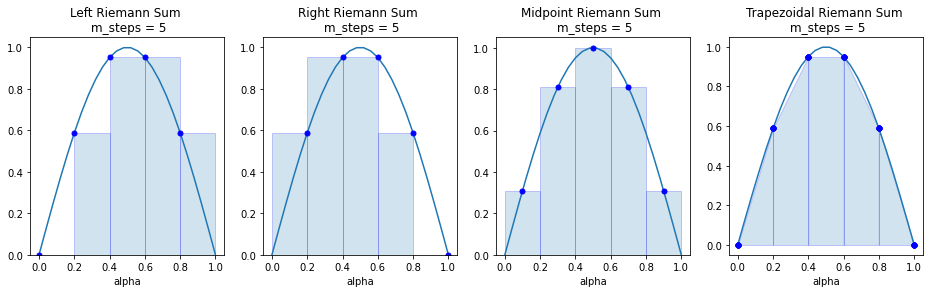

In [28]:
_ = plot_riemann_sums(lambda x: tf.math.sin(x*math.pi), 0.0, 1.0, m_steps=5)

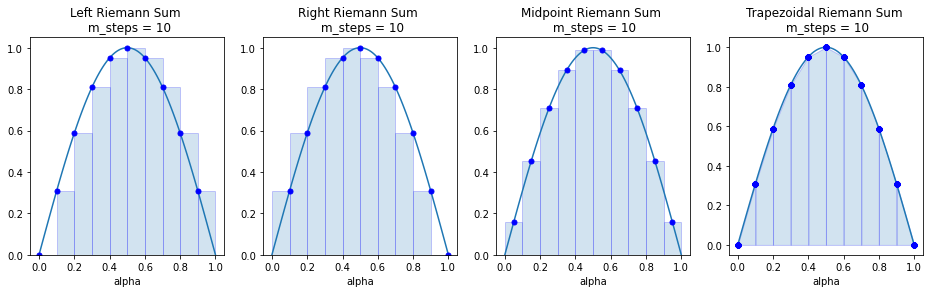

In [29]:
_ = plot_riemann_sums(lambda x: tf.math.sin(x*math.pi), 0.0, 1.0, m_steps=10)

**Which integral approximation method should you choose for IG?**

From the Riemann sum plots above you can see that the Trapezoidal Riemann Sum clearly provides a more accurate approximation and coverges more quickly over m_steps than the alternatives e.g. less white space under function not covered by shapes. Consequently, it is presented as the default method in the code below while also showing alternative methods for further study. Additional support for Trapezoidal Riemann approximation for IG is presented in section 4 of ["Computing Linear Restrictions of Neural Networks"](https://arxiv.org/abs/1908.06214).

Let us return to the $\alpha$ constant previously introduced in the *Generate interpolated path inputs* section for varying the intensity of the interpolated images between the baseline and input image. In the `generate_alphas` function below, you can see that $\alpha$ changes with each approximation method to reflect different start and end points and underlying geometric shapes of either a rectangle or trapezoid used to approximate the integral area. It takes a `method` parameter and a `m_steps` parameter that controls the accuracy of the integral approximation.

In [30]:
def generate_alphas(m_steps=50,
                    method='riemann_trapezoidal'):
  """
  Args:
    m_steps(Tensor): A 0D tensor of an int corresponding to the number of linear
      interpolation steps for computing an approximate integral. Default is 50.
    method(str): A string representing the integral approximation method. The 
      following methods are implemented:
      - riemann_trapezoidal(default)
      - riemann_left
      - riemann_midpoint
      - riemann_right
  Returns:
    alphas(Tensor): A 1D tensor of uniformly spaced floats with the shape 
      (m_steps,).
  """
  m_steps_float = tf.cast(m_steps, float) # cast to float for division operations.

  if method == 'riemann_trapezoidal':
    alphas = tf.linspace(0.0, 1.0, m_steps+1) # needed to make m_steps intervals.
  elif method == 'riemann_left':
    alphas = tf.linspace(0.0, 1.0 - (1.0 / m_steps_float), m_steps)
  elif method == 'riemann_midpoint':
    alphas = tf.linspace(1.0 / (2.0 * m_steps_float), 1.0 - 1.0 / (2.0 * m_steps_float), m_steps)
  elif method == 'riemann_right':    
    alphas = tf.linspace(1.0 / m_steps_float, 1.0, m_steps)
  else:
    raise AssertionError("Provided Riemann approximation method is not valid.")

  return alphas

In [31]:
alphas = generate_alphas(m_steps=20, method='riemann_trapezoidal')

In [32]:
alphas.shape

TensorShape([21])

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{4. Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{4. Divide by m steps}$

From the equation, you can see you are summing over m gradients and dividing by m steps. You can implement the two operations together for step 4 as an *average of the local gradients of m interpolated predictions and input images*.

In [33]:
def integral_approximation(gradients, 
                           method='riemann_trapezoidal'):
  """Compute numerical approximation of integral from gradients.

  Args:
    gradients(Tensor): A 4D tensor of floats with the shape 
      (m_steps, img_height, img_width, 3).
    method(str): A string representing the integral approximation method. The 
      following methods are implemented:
      - riemann_trapezoidal(default)
      - riemann_left
      - riemann_midpoint
      - riemann_right 
  Returns:
    integrated_gradients(Tensor): A 3D tensor of floats with the shape
      (img_height, img_width, 3).
  """
  if method == 'riemann_trapezoidal':  
    grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  elif method == 'riemann_left':
    grads = gradients
  elif method == 'riemann_midpoint':
    grads = gradients
  elif method == 'riemann_right':    
    grads = gradients
  else:
    raise AssertionError("Provided Riemann approximation method is not valid.")

  # Average integration approximation.
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)


  return integrated_gradients

The `integral_approximation` function takes the gradients of the predicted probability of the "Giant Panda" class with respect to the interpolated images between the baseline and "Giant Panda" image.

In [34]:
ig = integral_approximation(
    gradients=path_gradients,
    method='riemann_trapezoidal')

You can confirm averaging across the gradients of m interpolated images returns an integrated gradients tensor with the same shape as the original "Giant Panda" image.

In [35]:
ig.shape

TensorShape([224, 224, 3])

#### Putting it all together

Now you will combine the previous steps together into an `IntegratedGradients` function. To recap: 

$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated path inputs = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{average gradients}$

In [36]:
@tf.function
def integrated_gradients(model,
                         baseline, 
                         input,  
                         target_class_idx,
                         m_steps=50,
                         method='riemann_trapezoidal',
                         batch_size=32
                        ):
  """
  Args:
    model(keras.Model): A trained model to generate predictions and inspect.
    baseline(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3) with the same shape as the input tensor.
    input(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3).
    target_class_idx(Tensor): An integer that corresponds to the correct 
      ImageNet class index in the model's output predictions tensor. Default 
        value is 50 steps.           
    m_steps(Tensor): A 0D tensor of an integer corresponding to the number of 
      linear interpolation steps for computing an approximate integral.
    method(str): A string representing the integral approximation method. The 
      following methods are implemented:
      - riemann_trapezoidal(default)
      - riemann_left
      - riemann_midpoint
      - riemann_right
    batch_size(Tensor): A 0D tensor of an integer corresponding to a batch
      size for alpha to scale computation and prevent OOM errors. Note: needs to
      be tf.int64 and shoud be < m_steps. Default value is 32.      
  Returns:
    integrated_gradients(Tensor): A 3D tensor of floats with the same 
      shape as the input tensor (image_height, image_width, 3).
  """

  # 1. Generate alphas.
  alphas = generate_alphas(m_steps=m_steps,
                           method=method)

  # Initialize TensorArray outside loop to collect gradients. Note: this data structure
  # is similar to a Python list but more performant and supports backpropogation.
  # See https://www.tensorflow.org/api_docs/python/tf/TensorArray for additional details.
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)

  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  # Note: this implementation opted for lightweight tf.range iteration with @tf.function.
  # Alternatively, you could also use tf.data, which adds performance overhead for the IG 
  # algorithm but provides more functionality for working with tensors and image data pipelines.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = generate_path_inputs(baseline=baseline,
                                                         input=input,
                                                         alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(model=model,
                                       path_inputs=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to TensorArray. Note: writing batch indices with
    # scatter() allows for uneven batch sizes. Note: this operation is similar to a Python list extend().
    # See https://www.tensorflow.org/api_docs/python/tf/TensorArray#scatter for additional details.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()
    
  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients,
                                         method=method)
    
  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (input - baseline) * avg_gradients

  return integrated_gradients

In [37]:
ig_attributions = integrated_gradients(model=inception_v1_classifier,
                          baseline=name_baseline_tensors['Baseline Image: Black'],
                          input=img_name_tensors['Giant Panda'],
                          target_class_idx=389,
                          m_steps=55,
                          method='riemann_trapezoidal')

In [38]:
ig_attributions.shape

TensorShape([224, 224, 3])

Again, you can check that the IG feature attributions have the same shape as the input "Giant Panda" image.

### Step 4: checks to pick number of steps for IG approximation

One of IG nice theoretical properties is **completeness**. It is desireable because it holds that IG feature attributions break down the entire model's output prediction. Each feature importance score captures each feature's individual contribution to the prediction, and when added together, you can recover the entire example prediction value itself as tidy book keeping. This provides a principled means to select the `m_steps` hyperparameter for IG.

$IntegratedGrads_i(x) = F(x) - F(x')$

where:

$F(x)$ = model's predictions on input at target class  
$F(x')$ = model's predictions on baseline at target class

You can translate this formula to return a numeric score, with 0 representing convergance, through the following:

$\delta(score) = \sum{(IntegratedGrads_i(x))} - (\sum{F(input)} - \sum{F(x')})$


The original paper suggests the number of steps to range between 20 to 300 depending upon the example and application for the integral approximation. In practice, this can vary up to a few thousand `m_steps` to achieve an integral approximation within 5% error of the actual integral. Visual result convergence can generally be achieved with far few steps.

In [39]:
def convergence_check(model, attributions, baseline, input, target_class_idx):
  """
  Args:
    model(keras.Model): A trained model to generate predictions and inspect.
    baseline(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3) with the same shape as the input tensor.
    input(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3).
    target_class_idx(Tensor): An integer that corresponds to the correct 
      ImageNet class index in the model's output predictions tensor. Default 
        value is 50 steps.   
  Returns:
    (none): Prints scores and convergence delta to sys.stdout.
  """
  # Your model's prediction on the baseline tensor. Ideally, the baseline score
  # should be close to zero.
  baseline_prediction = model(tf.expand_dims(baseline, 0))
  baseline_score = tf.nn.softmax(tf.squeeze(baseline_prediction))[target_class_idx]
  # Your model's prediction and score on the input tensor.
  input_prediction = model(tf.expand_dims(input, 0))
  input_score = tf.nn.softmax(tf.squeeze(input_prediction))[target_class_idx]
  # Sum of your IG prediction attributions.
  ig_score = tf.math.reduce_sum(attributions)
  delta = ig_score - (input_score - baseline_score)
  try:
    # Test your IG score is <= 5% of the input minus baseline score.
    tf.debugging.assert_near(ig_score, (input_score - baseline_score), rtol=0.05)
    tf.print('Approximation accuracy within 5%.', output_stream=sys.stdout)
  except tf.errors.InvalidArgumentError:
    tf.print('Increase or decrease m_steps to increase approximation accuracy.', output_stream=sys.stdout)
  
  tf.print('Baseline score: {:.3f}'.format(baseline_score))
  tf.print('Input score: {:.3f}'.format(input_score))
  tf.print('IG score: {:.3f}'.format(ig_score))     
  tf.print('Convergence delta: {:.3f}'.format(delta))

In [40]:
convergence_check(model=inception_v1_classifier,
                  attributions=ig_attributions, 
                  baseline=name_baseline_tensors['Baseline Image: Black'], 
                  input=img_name_tensors['Giant Panda'], 
                  target_class_idx=389)

Approximation accuracy within 5%.
Baseline score: 0.000
Input score: 0.894
IG score: 0.910
Convergence delta: 0.016


Through utilizing the completeness axiom and the corresponding `convergence` function above, you were able to identify that you needed about 50 steps to approximate feature importances within 5% error for the "Giant Panda" image.

### Step 5: visualize IG attributions

Finally, you are ready to visualize IG attributions. In order to visualize IG, you will utilize the plotting code below which sums the absolute values of the IG attributions across the color channels for simplicity to return a greyscale attribution mask for standalone visualization and overlaying on the original image. This plotting method captures the relative impact of pixels on the model's predictions well. Note that another visualization option for you to try is to preserve the direction of the gradient sign e.g. + or - for visualization on different channels to more accurately represent how the features might combine.

In [41]:
def plot_img_attributions(model,
                          baseline,                          
                          img,  
                          target_class_idx,
                          m_steps=50,                           
                          cmap=None,
                          overlay_alpha=0.4):
  """
  Args:
    model(keras.Model): A trained model to generate predictions and inspect.
    baseline(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3) with the same shape as the input tensor.
    img(Tensor): A 3D image tensor with the shape 
      (image_height, image_width, 3).
    target_class_idx(Tensor): An integer that corresponds to the correct 
      ImageNet class index in the model's output predictions tensor. Default 
        value is 50 steps.
    m_steps(Tensor): A 0D tensor of an integer corresponding to the number of 
      linear interpolation steps for computing an approximate integral.
    cmap(matplotlib.cm): Defaults to None. Reference for colormap options -
      https://matplotlib.org/3.2.1/tutorials/colors/colormaps.html. Interesting
      options to try are None and high contrast 'inferno'.
    overlay_alpha(float): A float between 0 and 1 that represents the intensity
      of the original image overlay.    
  Returns:
    fig(matplotlib.pyplot.figure): fig object to utilize for displaying, saving 
      plots.
  """
  # Attributions
  ig_attributions = integrated_gradients(model=model,
                          baseline=baseline,
                          input=img,
                          target_class_idx=target_class_idx,
                          m_steps=m_steps)

  convergence_check(model, ig_attributions, baseline, img, target_class_idx)
  
  # Per the original paper, take the absolute sum of the attributions across 
  # color channels for visualization. The attribution mask shape is a greyscale image
  # with shape (224, 224).
  attribution_mask = tf.reduce_sum(tf.math.abs(ig_attributions), axis=-1)

  # Visualization
  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0,0].set_title('Baseline Image')
  axs[0,0].imshow(baseline)
  axs[0,0].axis('off')

  axs[0,1].set_title('Original Image')
  axs[0,1].imshow(img)
  axs[0,1].axis('off') 

  axs[1,0].set_title('IG Attribution Mask')
  axs[1,0].imshow(attribution_mask, cmap=cmap)
  axs[1,0].axis('off')  

  axs[1,1].set_title('Original + IG Attribution Mask Overlay')
  axs[1,1].imshow(attribution_mask, cmap=cmap)
  axs[1,1].imshow(img, alpha=overlay_alpha)
  axs[1,1].axis('off')

  plt.tight_layout()

  return fig

Visual inspection of the IG attributions on the "Fireboat" image, show that Inception V1 identifies the water cannons and spouts as contributing to its correct prediction.

Approximation accuracy within 5%.
Baseline score: 0.000
Input score: 0.326
IG score: 0.327
Convergence delta: 0.001


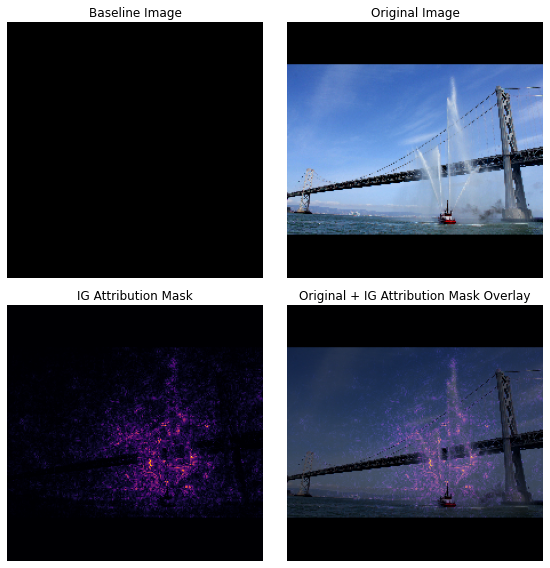

In [42]:
_ = plot_img_attributions(model=inception_v1_classifier,
                          img=img_name_tensors['Fireboat'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                          
                          target_class_idx=555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

Increase or decrease m_steps to increase approximation accuracy.
Baseline score: 0.000
Input score: 0.000
IG score: -0.000
Convergence delta: 0.000


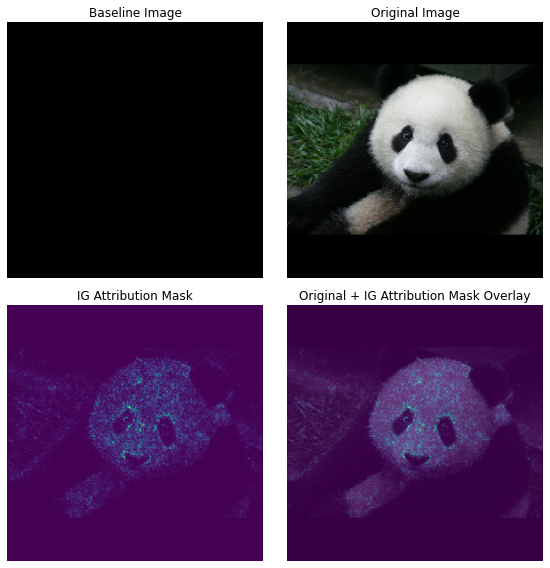

In [44]:
_ = plot_img_attributions(model=inception_v1_classifier,
                          img=img_name_tensors['Giant Panda'],
                          baseline=name_baseline_tensors['Baseline Image: Black'],                          
                          target_class_idx=780,
                          m_steps=100,
                          cmap=None,
                          overlay_alpha=0.2)

Returning to the "Giant Panda" image, IG attributions hightlight the texture, nose shape, and white fur of the Panda's face.

### How do different baselines impact interpretation of IG attributions?

In the section **Step 2: Establish baseline to compare against inputs**, the explanation from the original IG paper and discussion recommended a black baseline image to "ignore" and allow for interpretation of the predictions solely as a function of the input pixels. To motivate the choice of a black baseline image for interpretation, lets take a look at how a random baseline influences IG attributions.

Recall from above that a black baseline with the fireboat image, the IG attributions were primarily focused on the right water cannon on the fireboat. Now with a random baseline, the interpretation is much less clear. The IG attribution mask below shows a hazy attribution cloud of varying pixel intensity around the entire region of the water cannon streams. Are these truly significant features identified by the model or artifacts of random dark pixels from the random basline? Inconclusive without more investigation. The random baseline has changed interpretation of the pixel intensities from being solely in relation to the input features to input features plus spurious attributions from the baseline.

Approximation accuracy within 5%.
Baseline score: 0.000
Input score: 0.326
IG score: 0.325
Convergence delta: -0.001


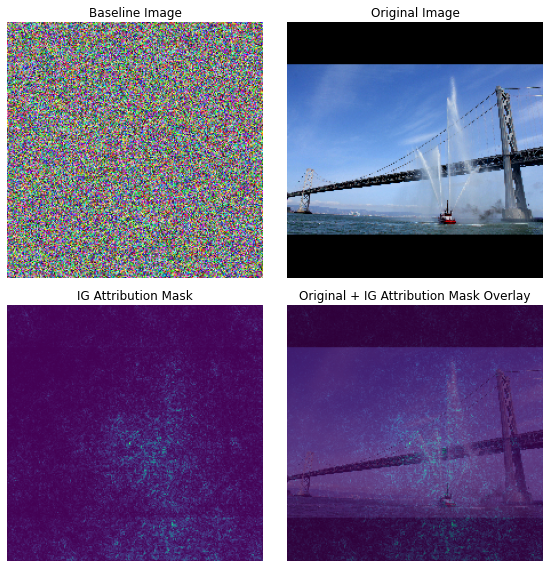

In [45]:
_ = plot_img_attributions(model=inception_v1_classifier,
                          img=img_name_tensors['Fireboat'],
                          baseline=name_baseline_tensors['Baseline Image: Random'],                          
                          target_class_idx=555,
                          m_steps=240,
                          cmap=None,
                          overlay_alpha=0.3)

Ultimately, picking any constant color baseline has potential interpretation problems through just visual inspection alone without consideration of the underlying values and their signs. Baseline selection is still an area of active research with various proposals e.g. averaging multiple random baselines, blurred inputs, etc. discussed in depth in the distill.pub article [Visualizing the Impact of Feature Attribution Baselines](https://distill.pub/2020/attribution-baselines/).

## Use cases

IG is a model-agnostic interpretability method that can be applied to any differentiable model (e.g. neural networks) to understand its predictions in terms of its input features; whether they be images, video, text, or structured data.

**At Google, IG has been applied in 20+ product areas to recommender system, classification, and regression models for feature importance and selection, model error analysis, train-test data skew monitoring, and explaining model behavior to stakeholders.**

## Properties

To summarize, IG is a popular Explainable AI method because of its broad applicability to any differentiable model, ease of implementation as this tutorial demonstrated, and relative computational efficiency compared to alternative explainability approaches that allows it to scale to large networks and feature spaces (e.g. images).

Explainable AI techniques are challenging to empirically evaluate and compare against each other. A secondary contribution of the original IG paper was to establish several axioms to evaluate explainability approaches and guide their own development of IG. Below are the axioms related to this tutorial and restated for clarity:

*   **Completeness**: the sum of IG attributions of all features is equal to the difference in your model's output for its input features and your model's output for the basline. The implications of this property are that you have a theoretical basis to determine how well IG's integral approximation converged and how you should adjust the number of steps hyperparameter. This was discussed previously in the tutorial in section *Step 4: Checks to pick number of steps for IG approximation* of this tutorial.

*   **Sensitivity**: all input features that differ between the input and baseline and result in different predictions will a non-zero attribution by IG. Conversely, any feature that does not impact the model's function will not receive any attribution. The practical implication of sensitivity is that you can count on IG to identify all feature importances and be more resistant to spurious attributions compared to just gradients. The key is in proper selection of the baseline as discussed in sections *Step 2: Establish baseline to compare inputs against* and *How do different baselines impact interpretation of IG attributions?*

*   **Implementation Invariance**: IG attributions will be the same for functionally equivalent models that output the same value for any given input. This is important to note in practice when interpretting and communicating results, because models with vastly different architectures and hyperparameters, can have identical IG attributions.

*   **Linearity**: Gradients are a natural analog to coefficients in linear models. IG attributions preserve linear relationships in the model. This includes linear combinations of different models; for these combined ensembled models, attributions represented the weighted sum between the individual model's attributions.






## Limitations


*   **IG provides local, not global interpretability**: IG provides a theoretically sound understanding of feature importances on individual examples. However, it does not provide a relative global feature importance for understanding overall model performance across data sets. For image data, there is no clear way to aggregate feature attributions of individual image pixels for global model interpretability. Individual pixels by themselves carry little meaning; its through their combination with other pixels into higher order features (e.g. edges, shapes) that you can determine meaning. For structured numeric and text data, you can apply statistical aggregations (e.g. mean) across the absolute value of IG attributions to various sets of examples to get a sense of a model's global feature importances relative to selected baselines. Although it is importance to keep in mind interpretation of these results can be potentially misleading and sensitive to feature baseline selection and relationships between features.

*   **IG explains network predictions in relation to individual features, not feature interactions and combinations**: Deep Neural Networks are powerful universal function approximators due to flexible function fitting capabilities that non-linearities (e.g. activation functions) introduce. However, IG is doing a first-order linear approximation of the functional relationship between model outputs and individual input features so you still do not know how the individual features interact, which are correlated, and how the network combines features to make its prediction.

*   **IG can only be applied to differentiable ML models**: IG can be applied to any differentiable models such as neural networks. However, this method cannot be applied to other types of ML models without modification such as tree-based models or model ensembles that involve non-differentiable parts.

*   **Limitations of baseline selection and visual inspection**: As this tutorial highlighted, proper interpretation of IG feature attributions depends upon selection of a good baseline. A black image is a great choice in most scenarios to limit interpretation of the prediction to the input features without any artifacts from the baseline but is limited when pixels important to the prediction are black themselves. As a result, visual inspection of the IG prediction attributions does not by itself always highlight all pixels of importance and may require trying out a few different baselines and contrastive explanations to fully understand the model's learned representation.




## Next steps

In this tutorial, you walked through an application of IG to understand an image classification network and use cases for IG in production machine learning workflows. As a next step, use this notebook to try out IG with different models, images, and baselines for yourself.

To go deeper with your understanding of IG, review the original IG paper [Axiomatic Attribution for Deep Networks](https://arxiv.org/abs/1703.01365) by Mukund Sundararajan et al. as well as section 4 of [Computing Linear Restrictions of Neural Networks](https://arxiv.org/abs/1908.06214) by Matthew Sotoudeh and Aditya V. Thakur. for a study on various methods to calculate approximate IG. You can also review the paper author's [Integrated Gradients Github repository](https://github.com/ankurtaly/Integrated-Gradients) for additional resources and TensorFlow 1.x IG and visualization code. Within that repository, the [How to Use Integrated Gradients Guide](https://github.com/ankurtaly/Integrated-Gradients/blob/master/howto.md#sanity-checking-baselines) provides additional details on baseline selection for different problem framings and feature types. To see how IG compares to other image classification techniques, check out the Google PAIR research group's [Saliency Github repository](https://github.com/ankurtaly/Integrated-Gradients).

Interested in incorporating IG into your production machine learning workflows for feature importances, model error analysis, and data skew monitoring? Check out Google Cloud's [Explainable AI](https://cloud.google.com/explainable-ai) product that supports IG attributions and read through the excellent accompanying [AI Explainability Whitepaper](https://storage.googleapis.com/cloud-ai-whitepapers/AI%20Explainability%20Whitepaper.pdf) to learn more. The Google AI PAIR research group also open-sourced the [What-if tool](https://pair-code.github.io/what-if-tool/index.html#about) which can be used for model debugging, including visualizing IG feature attributions.